<a href="https://colab.research.google.com/github/stiflerGit/CAD-Mammography/blob/master/CNN_PT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN for Abnormality detection in mammography

## Computational Intelligence Project 18/19

In [0]:
# CONSTANTS

IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = 2
BATCH_SIZE    = 32 
NUM_EPOCHS    = 30
FREEZE_LAYERS = {"lower":0, "higher":3}  # freeze layers from lower to higher bound
# fraction of train dataset used for validation
val_split = 0.2

VERSION = '0.0.04'
# dataset
DATASET_PATH  = '/content/drive/My Drive/CI_FinalProject/'
TRAIN_IMGS_FILE_NAME = 'train_img_%d.npy' % IMAGE_SIZE[0]
TRAIN_LABELS_FILE_NAME = 'train_lab.npy'
TEST_IMGS_FILE_NAME = 'public_test_image_%d.npy' % IMAGE_SIZE[0]
TEST_LABELS_FILE_NAME = 'public_test_label.npy'
# model
WORK_PATH = '/content/drive/My Drive/PreTrained_CNN/v'+ VERSION
MODEL_NAME = 'model'
MODEL_EXT = '.h5'

In [0]:
from google.colab import drive
import os
drive.mount('/content/drive')

if not os.path.exists(WORK_PATH):
    os.makedirs(WORK_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# PRE-PROCESS DATASET

import numpy as np
from sklearn.model_selection import train_test_split

train_gray_imgs = np.load(os.path.join(DATASET_PATH, TRAIN_IMGS_FILE_NAME))
train_lbls = np.load(os.path.join(DATASET_PATH, TRAIN_LABELS_FILE_NAME))

print(train_lbls.shape) # 2864 images (it is a quite small dataset)
print(np.count_nonzero(train_lbls)) # 1546 
# 1546 images belong to class 1, this means 1318 images belong to class 0
# so our class distribution is good

# we have to equally distribute otherwise the error:
### Training and validation subsets have different number of classes after the 
### split. If your numpy arrays are sorted by the label, you might want to shuffle them.
# could be raised. This is due to the distribution of classes of the labels.
# for example after the split, the training labels set contains both class 1 and 2,
# and on the other hand validation labels set contains either class 1 or class 2.
# Even if the train data would cointain both the classes it's better to equally 
# distribute the two classes over the sets.
X_train, X_val, y_train, y_val = train_test_split(train_gray_imgs, train_lbls,
                                                  test_size=val_split, 
                                                  stratify=train_lbls)

train_samples = len(X_train)
valid_samples = len(X_val)

X_train = 1./32768 * X_train
X_train = X_train - 1.
X_val = 1./32768 * X_val
X_val = X_val - 1.
# this is done to transform the gray imgs into rgb images
X_train = np.stack((X_train,)*3, axis=-1)
X_val = np.stack((X_val,)*3, axis=-1)

del(train_gray_imgs)
del(train_lbls)

test_gray_imgs = np.load(os.path.join(DATASET_PATH, TEST_IMGS_FILE_NAME))
test_gray_imgs =1./32768 * test_gray_imgs
test_gray_imgs = test_gray_imgs - 1.
test_rgb_imgs = np.stack((test_gray_imgs,)*3, axis=-1)
test_lbls = np.load(os.path.join(DATASET_PATH, TEST_LABELS_FILE_NAME))

del(test_gray_imgs)

(2864,)
1546


In [0]:
# PRE-PROCESS DATASET 

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=15, 
#     zoom_range=[1.5, 0], 
#     rescale=1./65536, 
    horizontal_flip=True, vertical_flip=True
)

train_iterator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

test_datagen = ImageDataGenerator()
validation_iterator = test_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)
test_iterator = test_datagen.flow(test_rgb_imgs, test_lbls, batch_size=BATCH_SIZE)

Using TensorFlow backend.


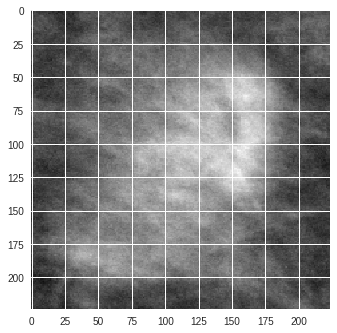

In [0]:
# Input example
import matplotlib.pyplot as plt
from keras.preprocessing import image

img = test_rgb_imgs[10]
plt.figure()

plt.imshow(image.array_to_img(img))

Since our data-set contains only 2864 images we have to deal with a *Small Dataset Problem* . 

Looking only to what we have learned in the lessons we have either 3 way to follow:


1. Data augmentation
2. Feature extraction with pre-trained network
3. Fine-Tuning a pre-trained network

In [0]:
from keras.applications import VGG16
from keras import layers
from keras import models
from keras import optimizers

net = VGG16(weights='imagenet',
                  include_top = False,
                  input_shape =(IMAGE_SIZE[0],IMAGE_SIZE[1], 3))

for layer in net.layers[:FREEZE_LAYERS["lower"]]:
    layer.trainable = True
for layer in net.layers[FREEZE_LAYERS["lower"]:FREEZE_LAYERS["higher"]]:
    layer.trainable = False
for layer in net.layers[FREEZE_LAYERS["higher"]:]:
    layer.trainable = True
    
net.summary()
net_final = models.Sequential()
net_final.add(net)
net_final.add(layers.Flatten())
net_final.add(layers.Dropout(0.4))
net_final.add(layers.Dense(512, activation="relu"))
net_final.add(layers.Dropout(0.4))
net_final.add(layers.Dense(512, activation="relu"))
net_final.add(layers.Dropout(0.4))
net_final.add(layers.Dense(NUM_CLASSES, activation='softmax', name='softmax'))

net_final.summary()

net_final.compile(
    optimizer=optimizers.Adam(lr=4e-5),
#     optimizer=optimizers.RMSprop(lr=7e-5),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bloc

In [0]:
history = net_final.fit_generator(train_iterator, 
                              steps_per_epoch=train_samples // BATCH_SIZE, 
                              epochs=NUM_EPOCHS,
#                               callbacks=[early_stopping],
                              validation_data=validation_iterator,
                              validation_steps=valid_samples // BATCH_SIZE)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
71/71 [==============================] - 65s 916ms/step - loss: 0.6098 - acc: 0.6783 - val_loss: 0.3786 - val_acc: 0.8585
Epoch 2/50
71/71 [==============================] - 61s 864ms/step - loss: 0.3752 - acc: 0.8509 - val_loss: 0.3709 - val_acc: 0.8503
Epoch 3/50
71/71 [==============================] - 55s 770ms/step - loss: 0.3440 - acc: 0.8594 - val_loss: 0.2778 - val_acc: 0.8872
Epoch 4/50
71/71 [==============================] - 55s 769ms/step - loss: 0.3029 - acc: 0.8845 - val_loss: 0.2978 - val_acc: 0.8835
Epoch 5/50
71/71 [==============================] - 55s 769ms/step - loss: 0.2805 - acc: 0.8913 - val_loss: 0.2300 - val_acc: 0.9094
Epoch 6/50
71/71 [==============================] - 55s 768ms/step - loss: 0.2565 - acc: 0.8989 - val_loss: 0.2575 - val_acc: 0.9002
Epoch 7/50
71/71 [==============================] - 55s 769ms/step - loss: 0.2527 - acc: 0.9011 - val_loss: 0.2673 - val_acc: 0.8817
Epoch 8/50
71/71 [===

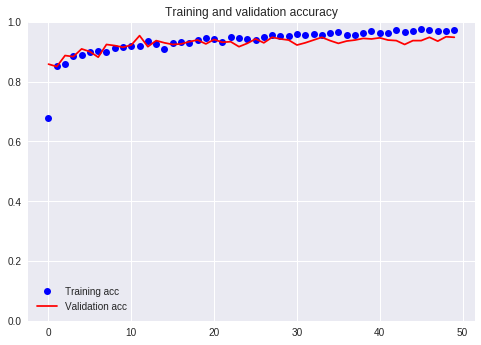

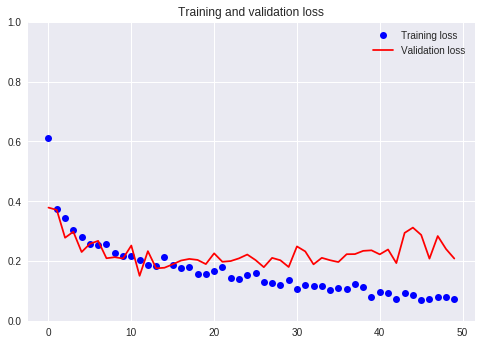

In [0]:
# plot the history
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.ylim((0,1))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.ylim((0,1))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

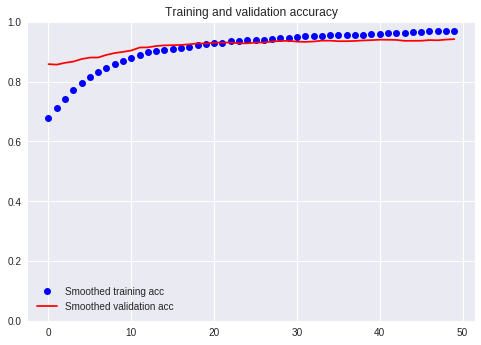

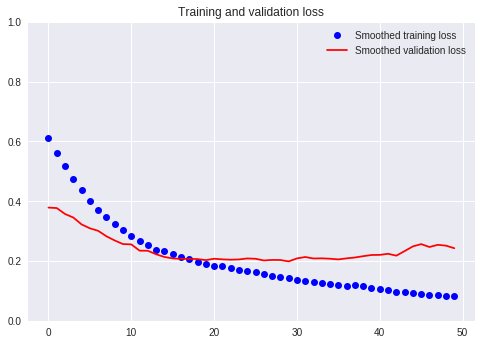

In [0]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.ylim((0,1))

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'r', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.ylim((0,1))

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'r', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
import numpy
# save model and history
net_final.save(os.path.join(WORK_PATH, MODEL_NAME + MODEL_EXT))
numpy.save(os.path.join(WORK_PATH,"loss"), numpy.array(history.history['loss']))
numpy.save(os.path.join(WORK_PATH,"val_loss"), numpy.array(history.history['val_loss']))
numpy.save(os.path.join(WORK_PATH,"acc"), numpy.array(history.history['acc']))
numpy.save(os.path.join(WORK_PATH,"val_acc"), numpy.array(history.history['val_acc']))

In [0]:
results = net_final.evaluate_generator(test_iterator, steps=22, verbose=1)

# #doesn't work
probabilities = net_final.predict(test_rgb_imgs)

print("test_loss: ", results[0], " test_acc: ", results[1])

22/22 [==============================] - 6s 294ms/step
test_loss:  0.3672899719835682  test_acc:  0.90625
